# Import Libraries

In [52]:
from google.colab import drive
drive.mount('/content/drive')
import os
import shutil
import cv2
import numpy as np
from pathlib import Path
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# An Algorithm for Detecting and Removing Predominantly Low-Intensity Images

In [3]:
class ImageSeperator:
  def __init__(self, dataset_path, lookfor, out):
    self.dataset_path = dataset_path
    self.source_folders = [os.path.join(self.dataset_path, f)
      for f in os.listdir(self.dataset_path)
      if os.path.isdir(os.path.join(self.dataset_path, f))]
    self.source_word = lookfor
    self.out = out
    self.valid_extensions = {".png", ".jpg", ".jpeg"}

  def is_mostly_black(self, img_path, mean_thresh=10, bright_pixel_ratio=0.2):
    img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
    if img is None:
        return True  # skip unreadable images

    mean_intensity = img.mean()

    # Ratio of pixels brighter than 50 (adjustable)
    bright_pixels = np.sum(img > 50)
    ratio = bright_pixels / img.size

    # Mostly black if mean very low OR almost all pixels are dark
    return mean_intensity < mean_thresh or ratio < bright_pixel_ratio

  def make_merged_directory(self, name):
    no_black_folder = os.path.join(name, self.out)
    os.makedirs(no_black_folder, exist_ok=True)
    return no_black_folder

  def process_images(self):
    for source in self.source_folders:
      source_path = Path(source) / self.source_word

      if not source_path.exists():
        print(f"⚠️ Skipping (no '{self.source_word}' folder): {source_path}")
        continue

      out_folder = self.make_merged_directory(source)

      print(f"Processing from: {source_path}")
      print(f"Outputting to: {out_folder}")

      if source_path.resolve() == Path(out_folder).resolve():
        print("⚠️ Source and destination are the same, skipping")
        continue

      # Process all images in source folder
      count_total = 0
      count_removed = 0
      for p in tqdm(source_path.glob("*.*")):
        if p.is_file() and p.suffix.lower() in self.valid_extensions:
          count_total += 1
          if self.is_mostly_black(p):
            count_removed += 1
            continue
          shutil.copy2(str(p), out_folder)

      print(f"Processed {count_total} images, removed {count_removed} mostly black images.")

## For MRI Images

In [4]:
mri_dataset_path = "/content/drive/MyDrive/Colab Notebooks/Data Science Group Project/data/interim/mri"
image_seperator = ImageSeperator(mri_dataset_path, lookfor="original", out="no_black")
image_seperator.process_images()

Processing from: /content/drive/MyDrive/Colab Notebooks/Data Science Group Project/data/interim/mri/glioma/original
Outputting to: /content/drive/MyDrive/Colab Notebooks/Data Science Group Project/data/interim/mri/glioma/no_black


10209it [08:38, 19.67it/s]


Processed 10209 images, removed 2509 mostly black images.
Processing from: /content/drive/MyDrive/Colab Notebooks/Data Science Group Project/data/interim/mri/meningioma/original
Outputting to: /content/drive/MyDrive/Colab Notebooks/Data Science Group Project/data/interim/mri/meningioma/no_black


10346it [09:21, 18.43it/s]


Processed 10346 images, removed 1516 mostly black images.
Processing from: /content/drive/MyDrive/Colab Notebooks/Data Science Group Project/data/interim/mri/no_tumor/original
Outputting to: /content/drive/MyDrive/Colab Notebooks/Data Science Group Project/data/interim/mri/no_tumor/no_black


1840it [01:17, 23.66it/s]


Processed 1840 images, removed 21 mostly black images.
Processing from: /content/drive/MyDrive/Colab Notebooks/Data Science Group Project/data/interim/mri/pituitary/original
Outputting to: /content/drive/MyDrive/Colab Notebooks/Data Science Group Project/data/interim/mri/pituitary/no_black


8203it [07:40, 17.81it/s]

Processed 8203 images, removed 1682 mostly black images.


In [20]:
no_black_glioma = len(os.listdir(os.path.join(mri_dataset_path, "glioma/no_black")))
no_black_meningioma = len(os.listdir(os.path.join(mri_dataset_path, "meningioma/no_black")))
no_black_no_tumor = len(os.listdir(os.path.join(mri_dataset_path, "no_tumor/no_black")))
no_black_pituitary = len(os.listdir(os.path.join(mri_dataset_path, "pituitary/no_black")))
total_mri_no_black_images = no_black_glioma + no_black_meningioma + no_black_no_tumor + no_black_pituitary

print("no_black_glioma:", no_black_glioma)
print("no_black_meningioma:", no_black_meningioma)
print("no_black_no_tumor:", no_black_no_tumor)
print("no_black_pituitary:", no_black_pituitary)
print("total_mri_no_black_images:", total_mri_no_black_images)

no_black_glioma: 7700
no_black_meningioma: 8830
no_black_no_tumor: 1819
no_black_pituitary: 6521
total_mri_no_black_images: 24870


In [23]:
mri_no_black_data = {"no_black_glioma": no_black_glioma,
                     "no_black_meningioma": no_black_meningioma,
                     "no_black_no_tumor": no_black_no_tumor,
                     "no_black_pituitary": no_black_pituitary}

## Bar plot to show class distribution/ imbalance

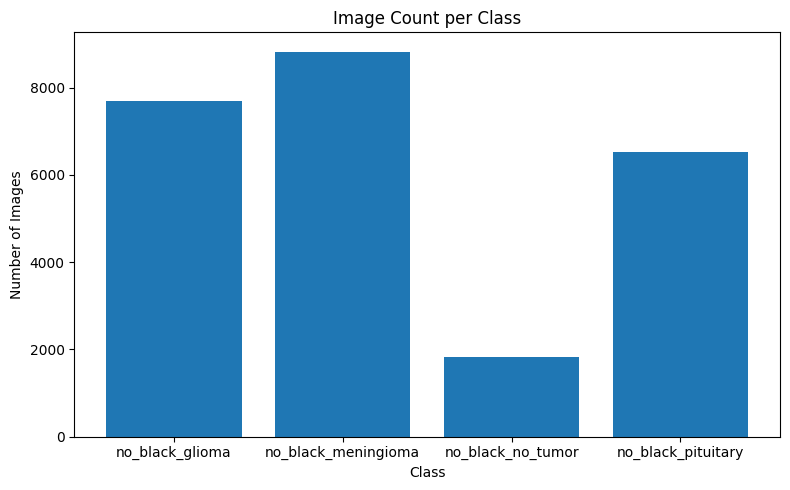

In [24]:
plt.figure(figsize=(8, 5))
plt.bar(mri_no_black_data.keys(), mri_no_black_data.values())
plt.title("Image Count per Class")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.tight_layout()
plt.show()

## Class proportions

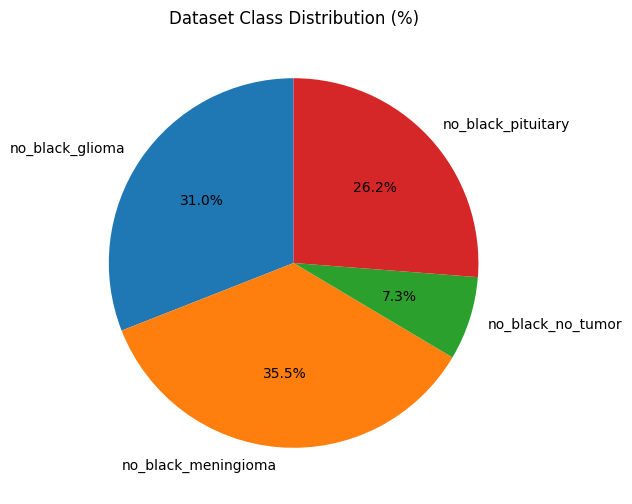

In [25]:
plt.figure(figsize=(6, 6))
plt.pie(mri_no_black_data.values(), labels=mri_no_black_data.keys(), autopct="%1.1f%%", startangle=90)
plt.title("Dataset Class Distribution (%)")
plt.show()

## Class imbalance ratio plot

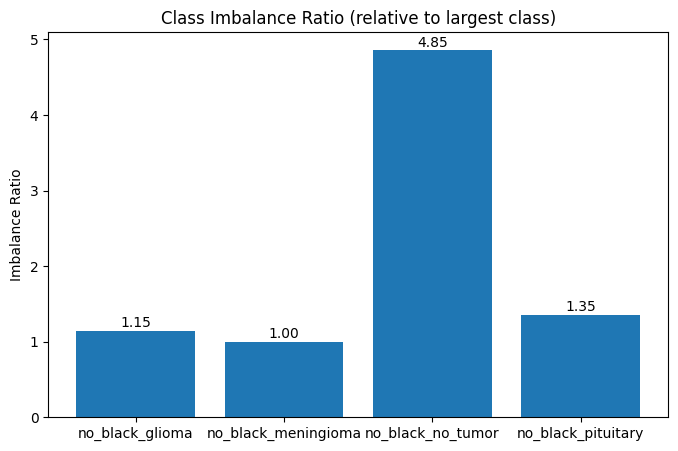

In [26]:
max_count = max(mri_no_black_data.values())
imbalance_ratio = [max_count / c for c in mri_no_black_data.values()]

plt.figure(figsize=(8, 5))
plt.bar(mri_no_black_data.keys(), imbalance_ratio)
plt.title("Class Imbalance Ratio (relative to largest class)")
plt.ylabel("Imbalance Ratio")
for i, v in enumerate(imbalance_ratio):
  plt.text(i, v + 0.05, f"{v:.2f}", ha="center")
plt.show()

## For CT Images

In [5]:
ct_dataset_path = "/content/drive/MyDrive/Colab Notebooks/Data Science Group Project/data/interim/ct"
image_seperator = ImageSeperator(ct_dataset_path, lookfor="original", out="no_black")
image_seperator.process_images()

Processing from: /content/drive/MyDrive/Colab Notebooks/Data Science Group Project/data/interim/ct/normal/original
Outputting to: /content/drive/MyDrive/Colab Notebooks/Data Science Group Project/data/interim/ct/normal/no_black


2300it [01:49, 21.06it/s]


Processed 2300 images, removed 13 mostly black images.
Processing from: /content/drive/MyDrive/Colab Notebooks/Data Science Group Project/data/interim/ct/tumor/original
Outputting to: /content/drive/MyDrive/Colab Notebooks/Data Science Group Project/data/interim/ct/tumor/no_black


2325it [01:59, 19.40it/s]

Processed 2325 images, removed 0 mostly black images.


In [19]:
no_black_normal = len(os.listdir(os.path.join(ct_dataset_path, "normal/no_black")))
no_black_tumor = len(os.listdir(os.path.join(ct_dataset_path, "tumor/no_black")))
total_ct_no_black_images = no_black_normal + no_black_tumor

print("no_black_normal:", no_black_normal)
print("no_black_tumor:", no_black_tumor)
print("total_ct_no_black_images:", total_ct_no_black_images)

no_black_normal: 2287
no_black_tumor: 2325
total_ct_no_black_images: 4612


In [18]:
ct_no_black_data = {"no_black_normal": no_black_normal,
                    "no_black_tumor": no_black_tumor}

## Bar plot to show class distribution/ imbalance

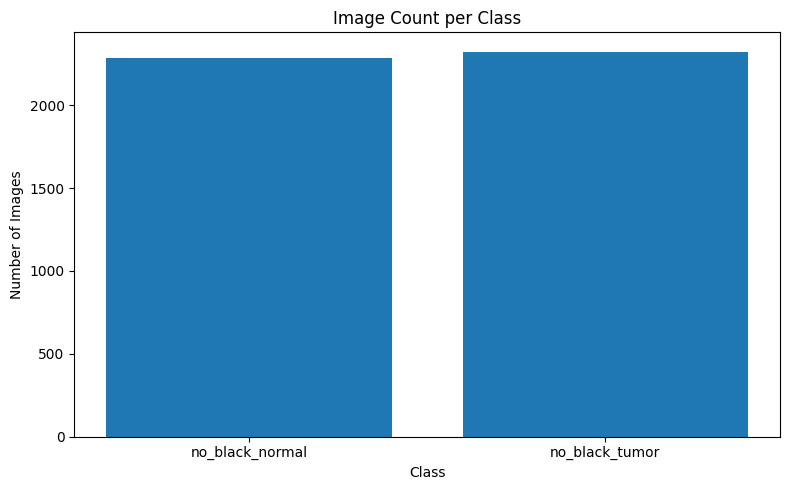

In [27]:
plt.figure(figsize=(8, 5))
plt.bar(ct_no_black_data.keys(), ct_no_black_data.values())
plt.title("Image Count per Class")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.tight_layout()
plt.show()

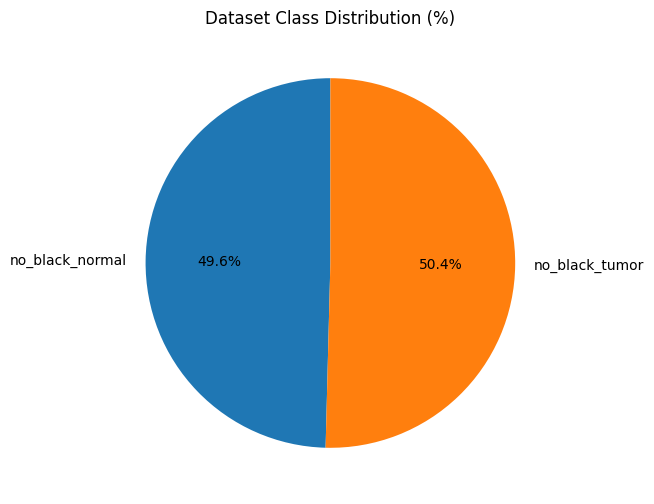

In [28]:
plt.figure(figsize=(6, 6))
plt.pie(ct_no_black_data.values(), labels=ct_no_black_data.keys(), autopct="%1.1f%%", startangle=90)
plt.title("Dataset Class Distribution (%)")
plt.show()

## Class imbalance ratio plot

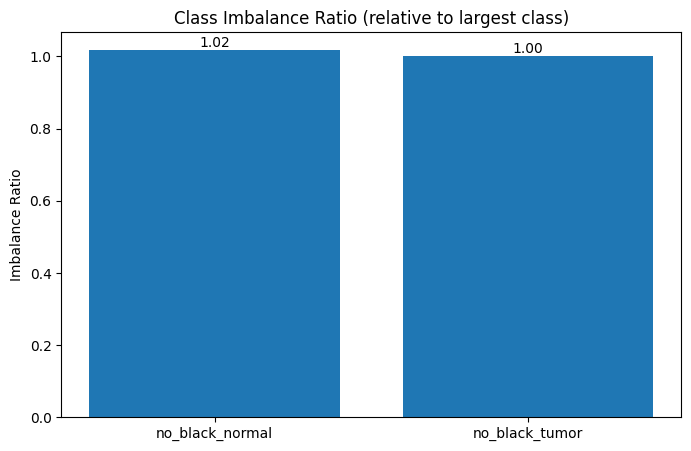

In [31]:
max_count = max(ct_no_black_data.values())
imbalance_ratio = [max_count / c for c in ct_no_black_data.values()]

plt.figure(figsize=(8, 5))
plt.bar(ct_no_black_data.keys(), imbalance_ratio)
plt.title("Class Imbalance Ratio (relative to largest class)")
plt.ylabel("Imbalance Ratio")
for i, v in enumerate(imbalance_ratio):
  plt.text(i, v + 0.01, f"{v:.2f}", ha="center")
plt.show()